# Simple Exponential Smoothing
> Use simple exponential smoothing method to model a non-seasonal time series with no trend.

- toc: true
- badges: true
- comments: true
- categories: [m249, timeseries]
- permalink: /2022/05/30/simple_exponential_smoothing_time_series/

## Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
from statsmodels import api as sm
from statsmodels import datasets
from statsmodels.tsa import api as tsa
from statsmodels.graphics import tsaplots
from matplotlib import pyplot as plt
import seaborn as sns

Set the graphing defaults.
(This is optional.)

In [2]:
sns.set_theme()
plt.rc("figure", figsize=(8, 6))
plt.rc("font", size=14)

## Notes

- Data was sourced from the Rdatasets
   - Arel-Bundock V (2022). Rdatasets: A collection of datasets originally distributed in various R packages. R package version 1.0.0, https://vincentarelbundock.github.io/Rdatasets.
- `Dataset` is a class from StatsModels
   - See [The Datasets Package](https://www.statsmodels.org/devel/datasets/index.html)
- Time series is non-seasonal and has no marked updward or downward trend, so it is reasonable to use simple exponential smoothing
- Model parameters
   - $\alpha \simeq$ 0.057959 $\to$ more weight is placed on distant past values, rather than more recent values
- Residuals
   - No sample autocorrelations exceed the 95% significance boundaries
   - Ljung-Box test yielded a test statistic = 16.24, *p* = 0.701
      - Little to no evidence against a white noise model
   - Time plot of forecasting errors shows no systematic change in level or variance
   - Histogram of forecasting errors shows assumption that the forecast errors are normally distributed is plausible

## Inputs/Outputs

### Inputs

- *bomregions* (`Dataset`), Australian and Related Historical Annual Climate Data, by region

### Intermediate

- *ts* (`Series`), annual Southern rainfall with `DatetimeIndex`
- *smoothed* (`SimpleExpSmoothing`), input *ts* modelled using simple exponential smoothing
   - See [SimpleExpSmoothing](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html)

### Outputs

- *fitted* (`HoltWintersResults`), fitted time series.
   - See [HoltWintersResults](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.HoltWintersResults.html#statsmodels.tsa.holtwinters.HoltWintersResults)
- *fcast* (`Series`), quantified forecast for the average precipitation in 2009

## Initialise the time series

### Load the data

In [3]:
bomregions = datasets.get_rdataset('bomregions', package='DAAG', cache=True)
bomregions.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       109 non-null    int64  
 1   eastAVt    99 non-null     float64
 2   seAVt      99 non-null     float64
 3   southAVt   99 non-null     float64
 4   swAVt      99 non-null     float64
 5   westAVt    99 non-null     float64
 6   northAVt   99 non-null     float64
 7   mdbAVt     99 non-null     float64
 8   auAVt      99 non-null     float64
 9   eastRain   109 non-null    float64
 10  seRain     109 non-null    float64
 11  southRain  109 non-null    float64
 12  swRain     109 non-null    float64
 13  westRain   109 non-null    float64
 14  northRain  109 non-null    float64
 15  mdbRain    109 non-null    float64
 16  auRain     109 non-null    float64
 17  SOI        109 non-null    float64
 18  co2mlo     50 non-null     float64
 19  co2law     79 non-null     float64
 20  CO2       

### Initialise the Series (Pandas)

The first observation is in 1900.

In [4]:
bomregions.data['Year'].head(1)

0    1900
Name: Year, dtype: int64

In [5]:
ts = pd.Series(
    data=bomregions.data['southRain'].to_numpy(),
    name='SOUTHERN RAINFALL',
    index=pd.date_range(
        start='1900',
        periods=bomregions.data['southRain'].size,
        freq='A-DEC',
        name='YEAR'
    )
)
ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 109 entries, 1900-12-31 to 2008-12-31
Freq: A-DEC
Series name: SOUTHERN RAINFALL
Non-Null Count  Dtype  
--------------  -----  
109 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


### Plot the time series

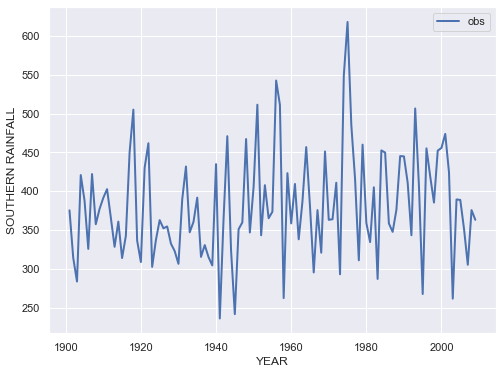

In [6]:
sns.lineplot(x=ts.index, y=ts, lw=2, label='obs')
plt.ylabel(ts.name)
plt.legend()
plt.show()

## Smooth the time series

In [7]:
smoothed = tsa.SimpleExpSmoothing(ts, initialization_method='estimated')
fitted = smoothed.fit()

Plot the observerved and fitted time series.

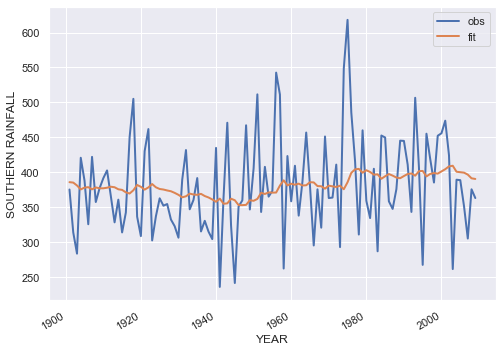

In [8]:
sns.lineplot(x=ts.index, y=ts, lw=2, label='obs')
fitted.fittedvalues.plot(lw=2, label='fit')
plt.ylabel(ts.name)
plt.legend()
plt.show()

### Model parameters

In [9]:
params = pd.Series(
    data={'alpha': fitted.params['smoothing_level'], 'sse': fitted.sse},
    name='smoothing parameters'
)
params

alpha         0.057959
sse      516565.109844
Name: smoothing parameters, dtype: float64

### Forecasting errors

#### Time series of the forecasting errors

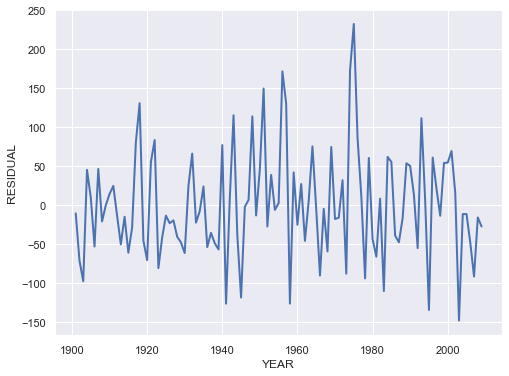

In [10]:
sns.lineplot(x=fitted.resid.index, y=fitted.resid, lw=2)
plt.ylabel('RESIDUAL')
plt.show()

#### In-sample autocorrelations

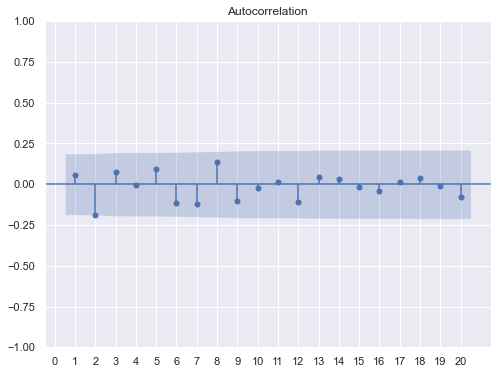

In [11]:
tsaplots.plot_acf(fitted.resid, lags=20, zero=False)
plt.xticks(range(21))
plt.show()

#### Ljung-Box test

In [12]:
sm.stats.acorr_ljungbox(fitted.resid, lags=[20])

,lb_stat,lb_pvalue
20,16.243305,0.70142


#### Histogram of the forecasting errors

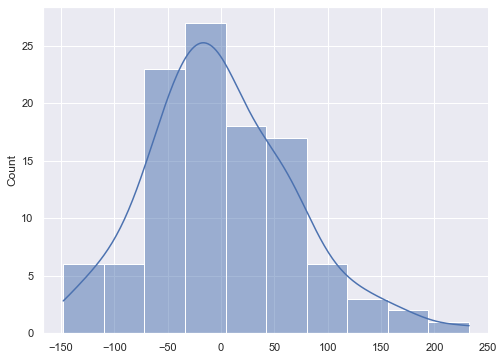

In [13]:
sns.histplot(x=fitted.resid, kde=True)
plt.show()

### Forecasting

#### Plot of forecasts (+3 years)

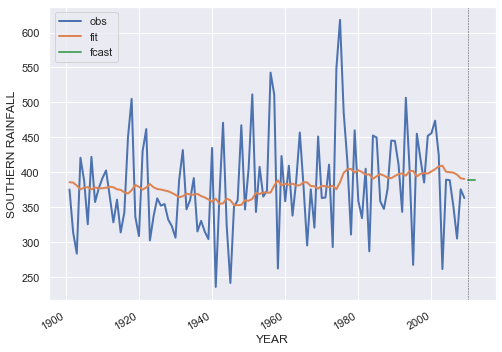

In [14]:
fcast3 = fitted.forecast(3)
sns.lineplot(x=ts.index, y=ts, lw=2, label='obs')
fitted.fittedvalues.plot(lw=2, label='fit')
fcast3.plot(lw=2, label='fcast')
plt.axvline(fcast3.index[0], alpha=0.7, lw=0.5, ls='--', color='black')
plt.legend()
plt.ylabel(ts.name)
plt.show()

#### Quantify a forecast

In [15]:
fcast = fitted.forecast(1)[0]
std_err = np.sqrt(
    st.norm().ppf(0.975) * (fitted.sse / fitted.fittedvalues.size)
)
pd.Series(
    data={'pred': fcast, 'lcb': fcast - std_err, 'ucb': fcast + std_err},
    name='2009 forecasted rainfall'
)

pred    388.927004
lcb     292.550020
ucb     485.303988
Name: 2009 forecasted rainfall, dtype: float64

## References

- M249, Book 2, Part 2.6 & 2.9